In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
import torch.optim as optim
from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import random
from sklearn.decomposition import NMF

In [2]:
lap = torch.load('model_single_laplacians_final.pth', weights_only=False)

In [3]:
# import labels for the shapes
shape_labels = np.genfromtxt('../FiltrationsForGNNs/Gudhi Shape Dataset/shape_labels.csv', delimiter=',', skip_header=1)
shape_labels = shape_labels.astype(int)[:,2]
print(shape_labels)

[1 1 1 ... 0 0 0]


In [4]:
num_samples = 1 # currently set to full dataset

# Generate random indices
random_indices = [1]
base = '../FiltrationsForGNNs/Gudhi Shape Dataset'
# Select the corresponding data and labels
laplacians = []
vr_persistence_images = []
abstract_persistence_images = []
selected_labels = []

for i in random_indices:
    laplacians.append(np.genfromtxt(f'{base}/shape_{i}_laplacian.csv', delimiter=',', skip_header=0))
    vr_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_vr_persistence_image.csv', delimiter=',', skip_header=0))
    abstract_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_abstract_persistence_image.csv', delimiter=',', skip_header=0))
    selected_labels.append(shape_labels[i])

# Convert selected labels to NumPy array
selected_labels = np.array(selected_labels)

# Print a summary
print(f"Randomly selected {num_samples} samples.")
print(f"Shape of laplacians: {np.array(laplacians).shape}")
print(f"Shape of VR persistence images: {np.array(vr_persistence_images).shape}")
print(f"Shape of abstract persistence images: {np.array(abstract_persistence_images).shape}")
print(f"Shape of selected labels: {selected_labels.shape}")

Randomly selected 1 samples.
Shape of laplacians: (1, 1000, 1000)
Shape of VR persistence images: (1, 100, 100)
Shape of abstract persistence images: (1, 100, 100)
Shape of selected labels: (1,)


In [5]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes=2):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive Pooling to resize to 100x100
        self.adaptive_pool = nn.AdaptiveAvgPool2d((100, 100))
        
        # Dynamically calculate input size to fc1
        self.feature_size = self._get_feature_size(input_shape)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.feature_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_feature_size(self, input_shape):
        # Create a dummy input to calculate size after conv and pooling
        dummy_input = torch.zeros(1, 1, *input_shape)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply adaptive pooling to get 100x100 size
        x = self.adaptive_pool(x)
        return x.numel()  # Number of elements after flattening

    def forward(self, x):
        # Apply convolutional layers with pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply adaptive pooling to resize to 100x100
        x = self.adaptive_pool(x)
        
        # Flatten and pass through fully connected layers
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [6]:
input_shape = laplacians[0].shape
num_classes = 2
lap = CNN(input_shape, num_classes)

In [7]:
lap.load_state_dict(torch.load('model_single_laplacians_final.pth', weights_only=True))

<All keys matched successfully>

In [8]:
def single_viz(model, data, name, d):
    model.eval()
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    for child in range(len(model_children)):
        if type(model_children[child]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[child].weight)
            conv_layers.append(model_children[child])
    image = np.float32(laplacians)
    image = torch.tensor(image)
    outputs = []
    names = []

    for layer in conv_layers:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)
    fig = plt.figure(figsize=(30, 50))
    a = fig.add_subplot(1,3,1)
    a.set_title(f"{name} {d} dimensional", fontsize=30)
    implot = plt.imshow(data[0])
    for i in range(len(processed)):
        a = fig.add_subplot(1, 3, i + 2)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(f"Conv Layer {i + 1}", fontsize=30)  # Adjust subplot title font size
    fig.savefig(
    f"{name}_{d}",
    bbox_inches="tight",  # Crop extra white space
    pad_inches=0.1,       # Add a small padding around the figure
    dpi=300               # Increase resolution (optional)
)

2
torch.Size([16, 1000, 1000])
torch.Size([32, 1000, 1000])
(1000, 1000)
(1000, 1000)


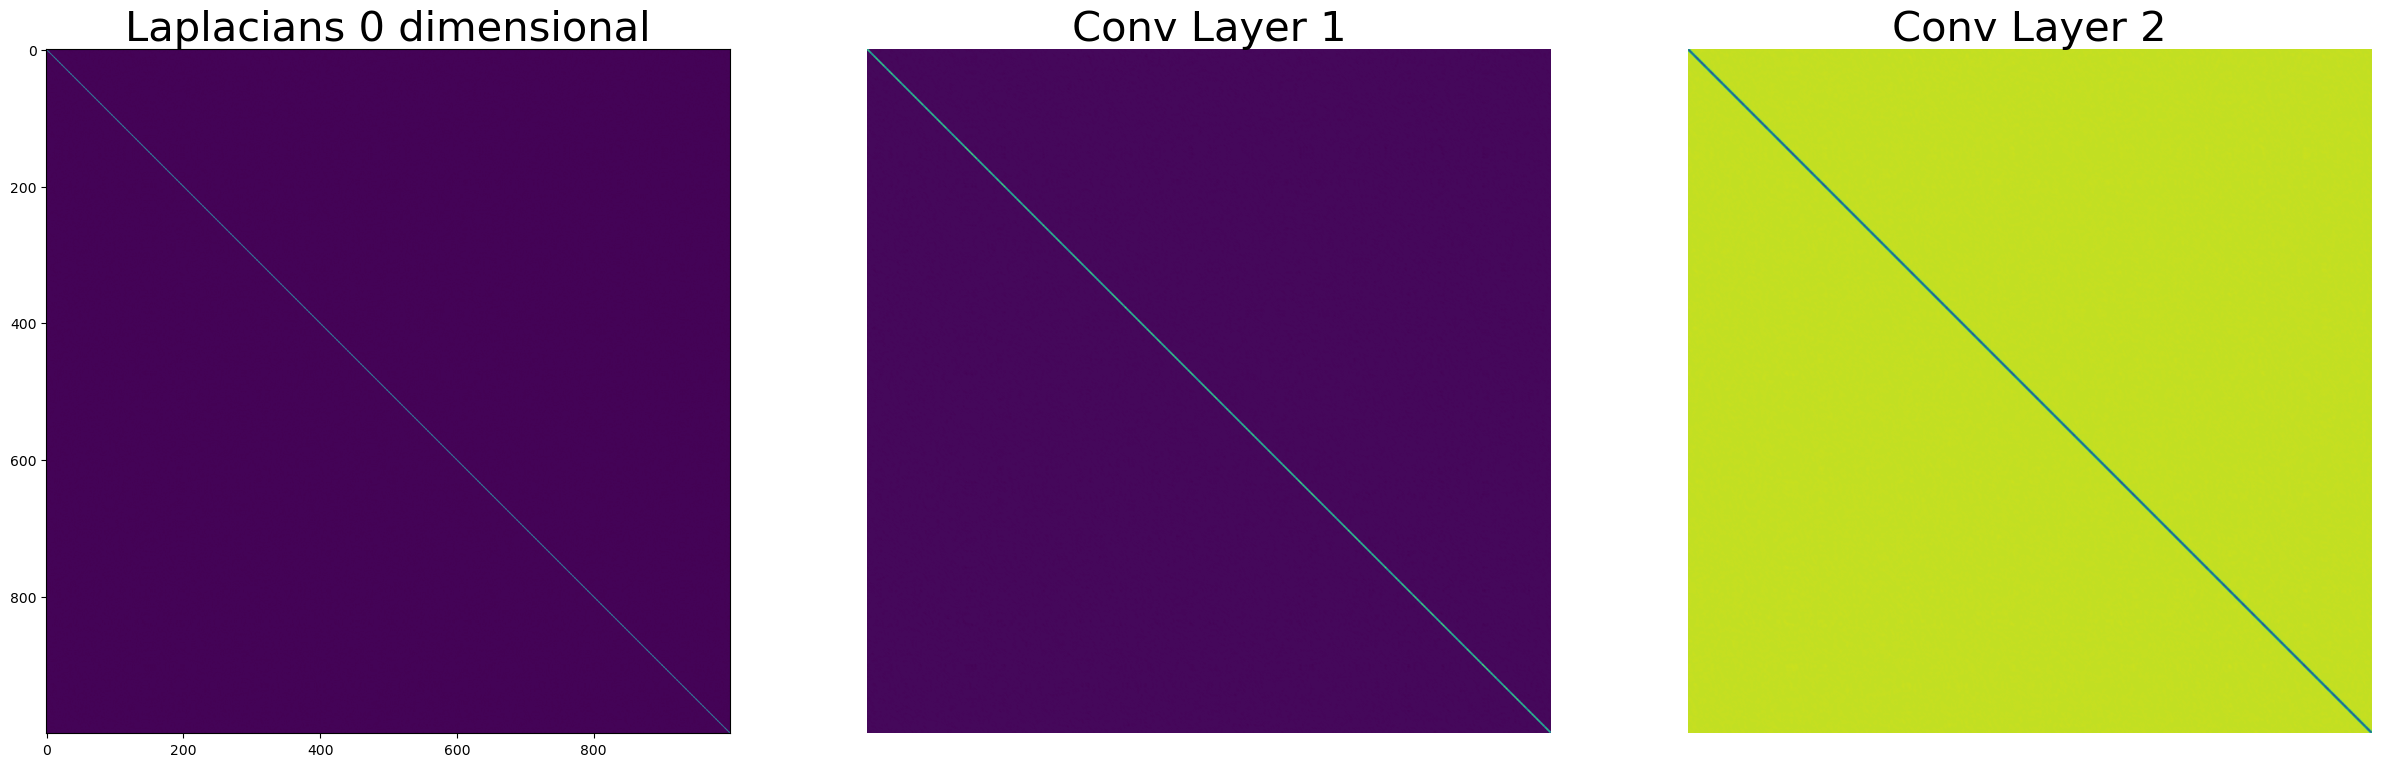

In [9]:
single_viz(lap, laplacians, "Laplacians", 0)

In [10]:
class DualInputCNN(nn.Module):
    def __init__(self, input_shape1, input_shape2, num_classes=2):
        super(DualInputCNN, self).__init__()

        # Laplacian input path with additional pooling to reduce to 100x100
        self.conv1_lap = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_lap = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool_lap = nn.MaxPool2d(2, 2)  # Reduce spatial dimensions
        self.adaptive_pool_lap = nn.AdaptiveAvgPool2d((100, 100))  # Resize to 100x100
        
        # Persistence image input path (no pooling)
        self.conv1_pers = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_pers = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.adaptive_pool_pers = nn.AdaptiveAvgPool2d((100, 100))  # Resize to 100x100
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 100 * 100 + 32 * 100 * 100, 128)  # Adjusted for 100x100 input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x1, x2):
        # Laplacians path (downsampling to 100x100)
        x1 = F.relu(self.conv1_lap(x1))
        x1 = self.pool_lap(x1)  # First pool: 250x250 -> 125x125
        x1 = F.relu(self.conv2_lap(x1))
        x1 = self.pool_lap(x1)  # Second pool: 125x125 -> 62x62
        x1 = self.adaptive_pool_lap(x1)  # Resize to 100x100
        
        # Persistence images path (no pooling)
        x2 = F.relu(self.conv1_pers(x2))
        x2 = F.relu(self.conv2_pers(x2))
        x2 = self.adaptive_pool_pers(x2)  # Ensure persistence images are 100x100
        
        # Concatenate along dim=1 (channels)
        x = torch.cat((x1, x2), dim=1)  # Concatenates the outputs along the channel axis

        # Flatten for fully connected layer
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [11]:

num_classes = 2 # binary classification

# For dual-input CNNs (Laplacians + VR Persistence Images, Laplacians + Abstract Persistence Images)
input_shape1 = laplacians[0].shape
input_shape2 = vr_persistence_images[0].shape
input_shape3 = abstract_persistence_images[0].shape

model_dual_lap_vr = DualInputCNN(input_shape1, input_shape2, num_classes)
model_dual_lap_abstract = DualInputCNN(input_shape1, input_shape3, num_classes)

In [12]:
model_dual_lap_vr.load_state_dict(torch.load('model_dual_lap_vr_final.pth', weights_only=True))
model_dual_lap_abstract.load_state_dict(torch.load('model_dual_lap_abstract_final.pth',weights_only=True))


<All keys matched successfully>

In [13]:
def feature_viz_persistance(model, data, name, d):
    model.eval()
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    for child in range(len(model_children)):
        if type(model_children[child]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[child].weight)
            conv_layers.append(model_children[child])

    image = np.float32(data)
    image = torch.tensor(image)
    outputs = []
    names = []

    for layer in conv_layers[2:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)
    
    fig = plt.figure(figsize=(30, 50),layout='constrained')  # Large figure size
    a = fig.add_subplot(1,3,1)
    a.set_title(f"{name} {d} dimensional", fontsize=30)
    implot = plt.imshow(data[0])
    for i in range(len(processed)):
        a = fig.add_subplot(1, 3, i + 2)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(f"Conv Layer {i + 1}", fontsize=30)  # Adjust subplot title font size
    # Add a centered suptitle with adjusted position
    fig.savefig(
    f"{name}_{d}",
    bbox_inches="tight",  # Crop extra white space
    pad_inches=0.1,       # Add a small padding around the figure
    dpi=300               # Increase resolution (optional)
)
    plt.show()

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


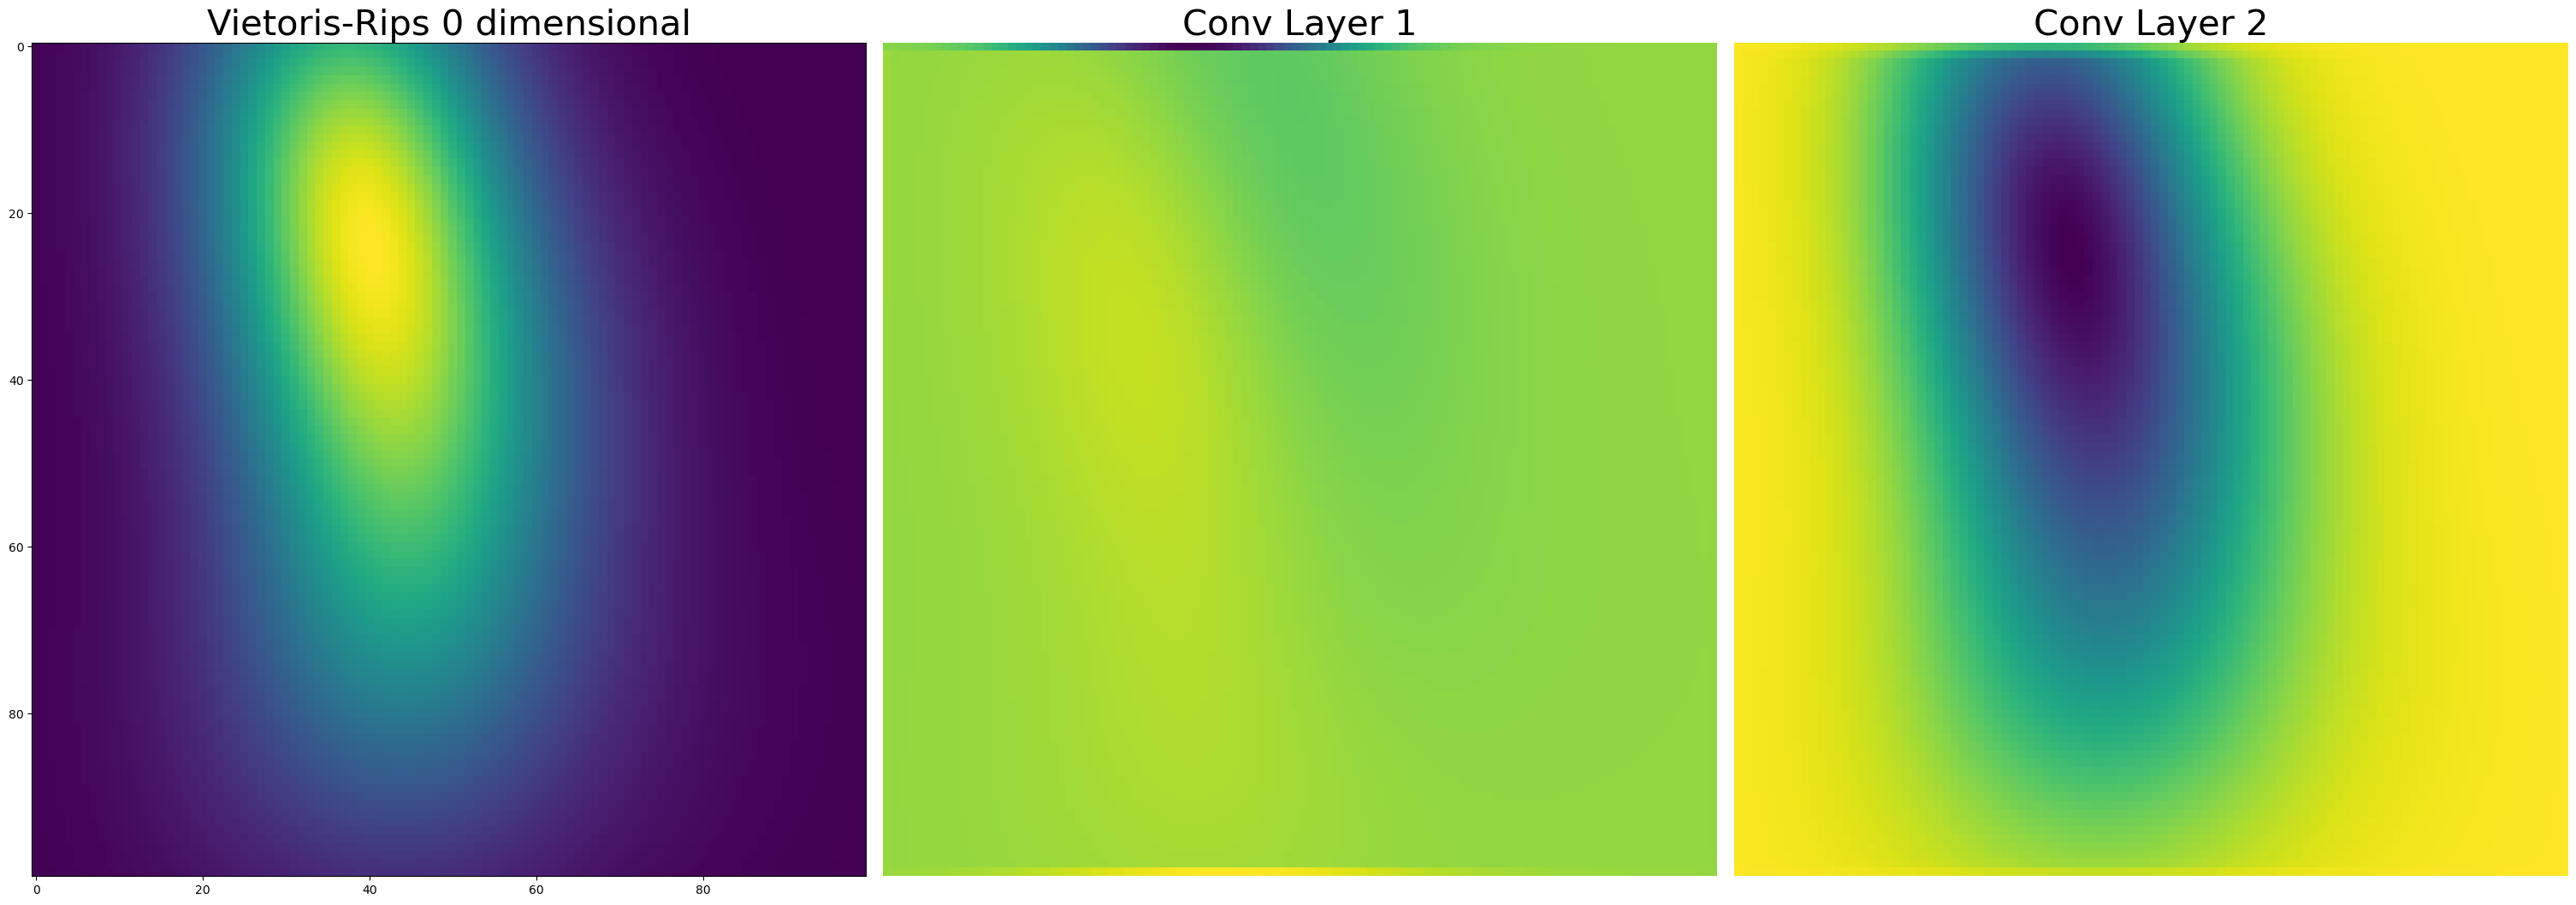

In [14]:
feature_viz_persistance(model_dual_lap_vr, vr_persistence_images, 'Vietoris-Rips', 0)

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


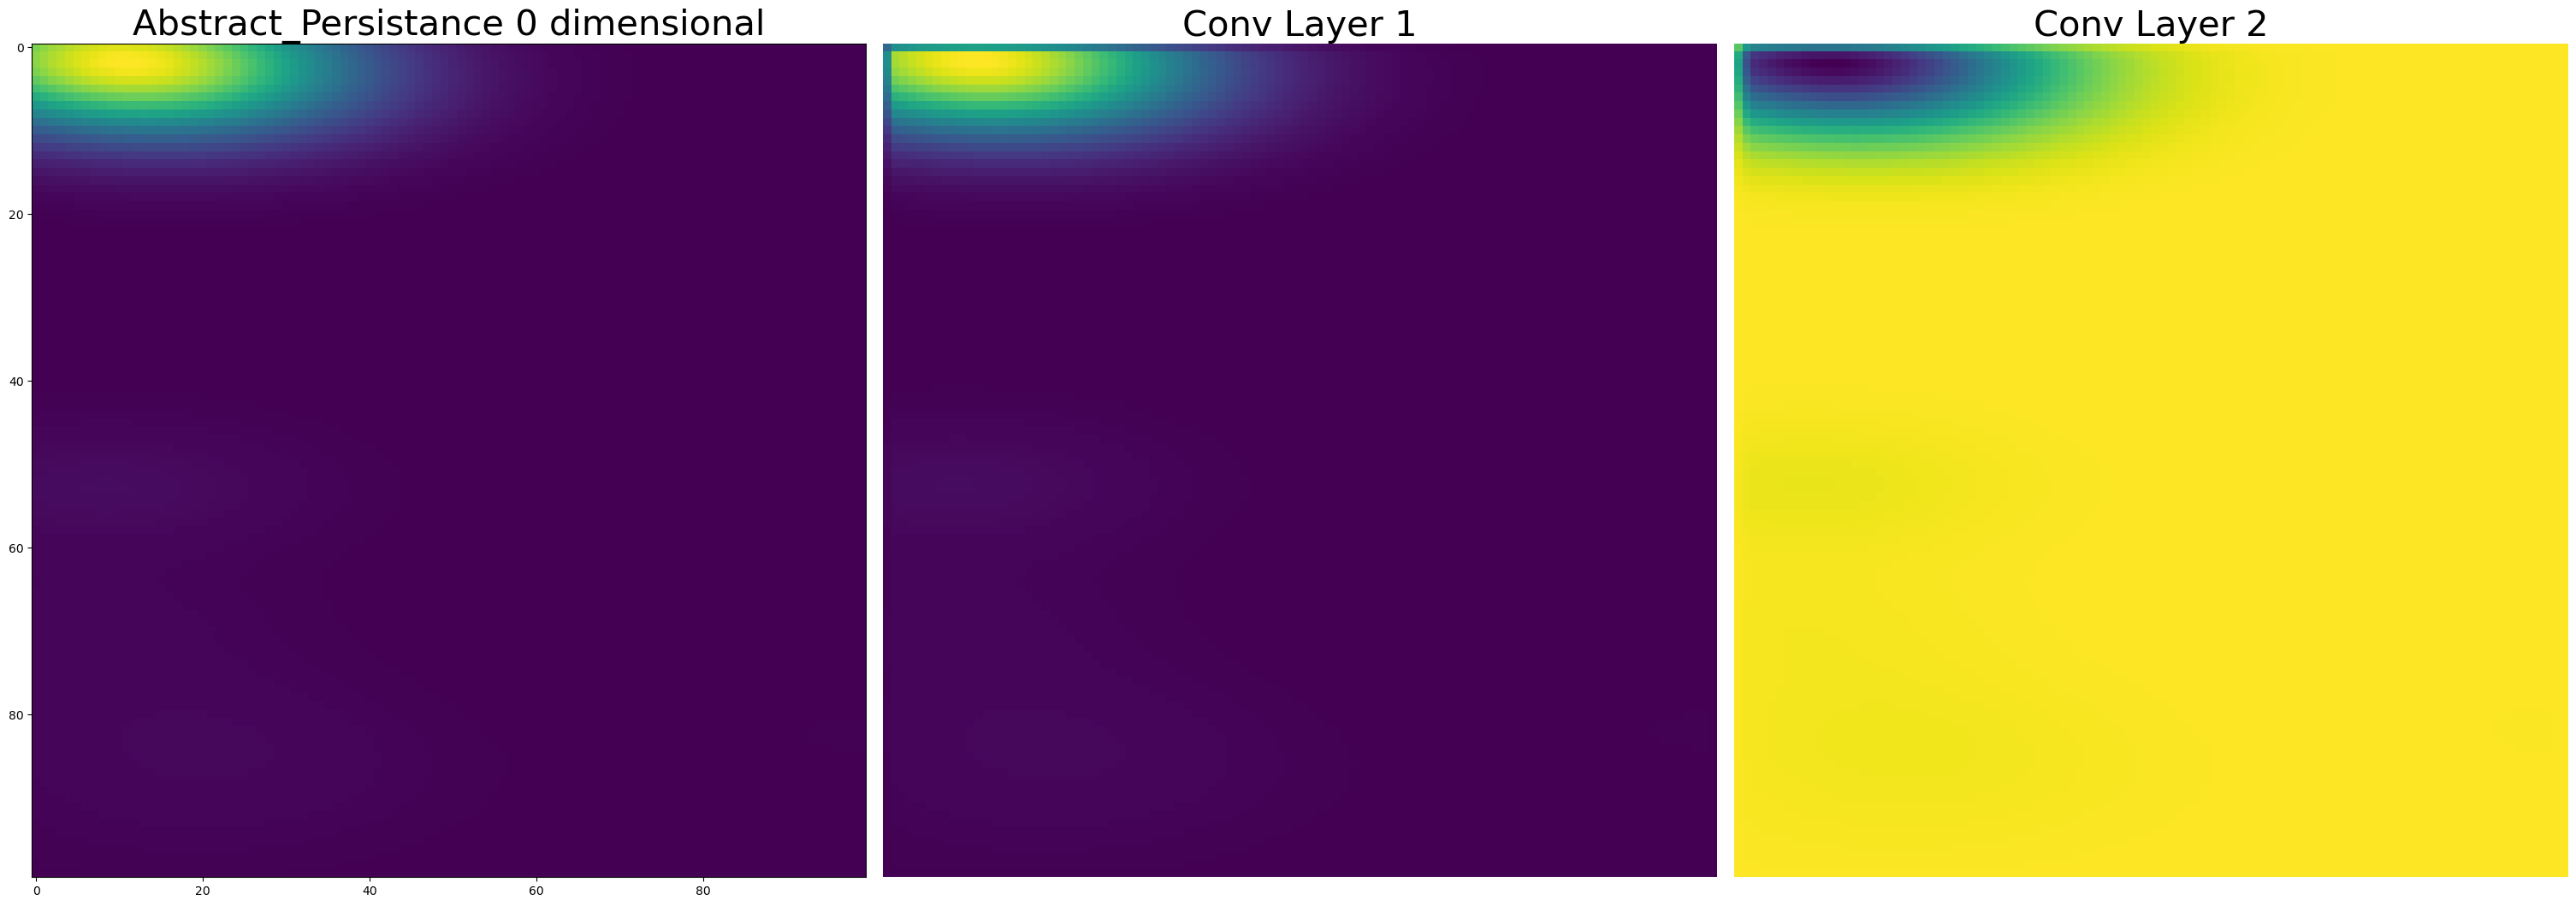

In [15]:
feature_viz_persistance(model_dual_lap_abstract, abstract_persistence_images, 'Abstract_Persistance', 0)

In [16]:
num_samples = 1 # currently set to full dataset

# Generate random indices
random_indices = [1500]
base = '../FiltrationsForGNNs/Gudhi Shape Dataset'
# Select the corresponding data and labels
laplacians = []
vr_persistence_images = []
abstract_persistence_images = []
selected_labels = []

for i in random_indices:
    laplacians.append(np.genfromtxt(f'{base}/shape_{i}_laplacian.csv', delimiter=',', skip_header=0))
    vr_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_vr_persistence_image.csv', delimiter=',', skip_header=0))
    abstract_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_abstract_persistence_image.csv', delimiter=',', skip_header=0))
    selected_labels.append(shape_labels[i])

# Convert selected labels to NumPy array
selected_labels = np.array(selected_labels)

# Print a summary
print(f"Randomly selected {num_samples} samples.")
print(f"Shape of laplacians: {np.array(laplacians).shape}")
print(f"Shape of VR persistence images: {np.array(vr_persistence_images).shape}")
print(f"Shape of abstract persistence images: {np.array(abstract_persistence_images).shape}")
print(f"Shape of selected labels: {selected_labels.shape}")

Randomly selected 1 samples.
Shape of laplacians: (1, 1000, 1000)
Shape of VR persistence images: (1, 100, 100)
Shape of abstract persistence images: (1, 100, 100)
Shape of selected labels: (1,)


2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


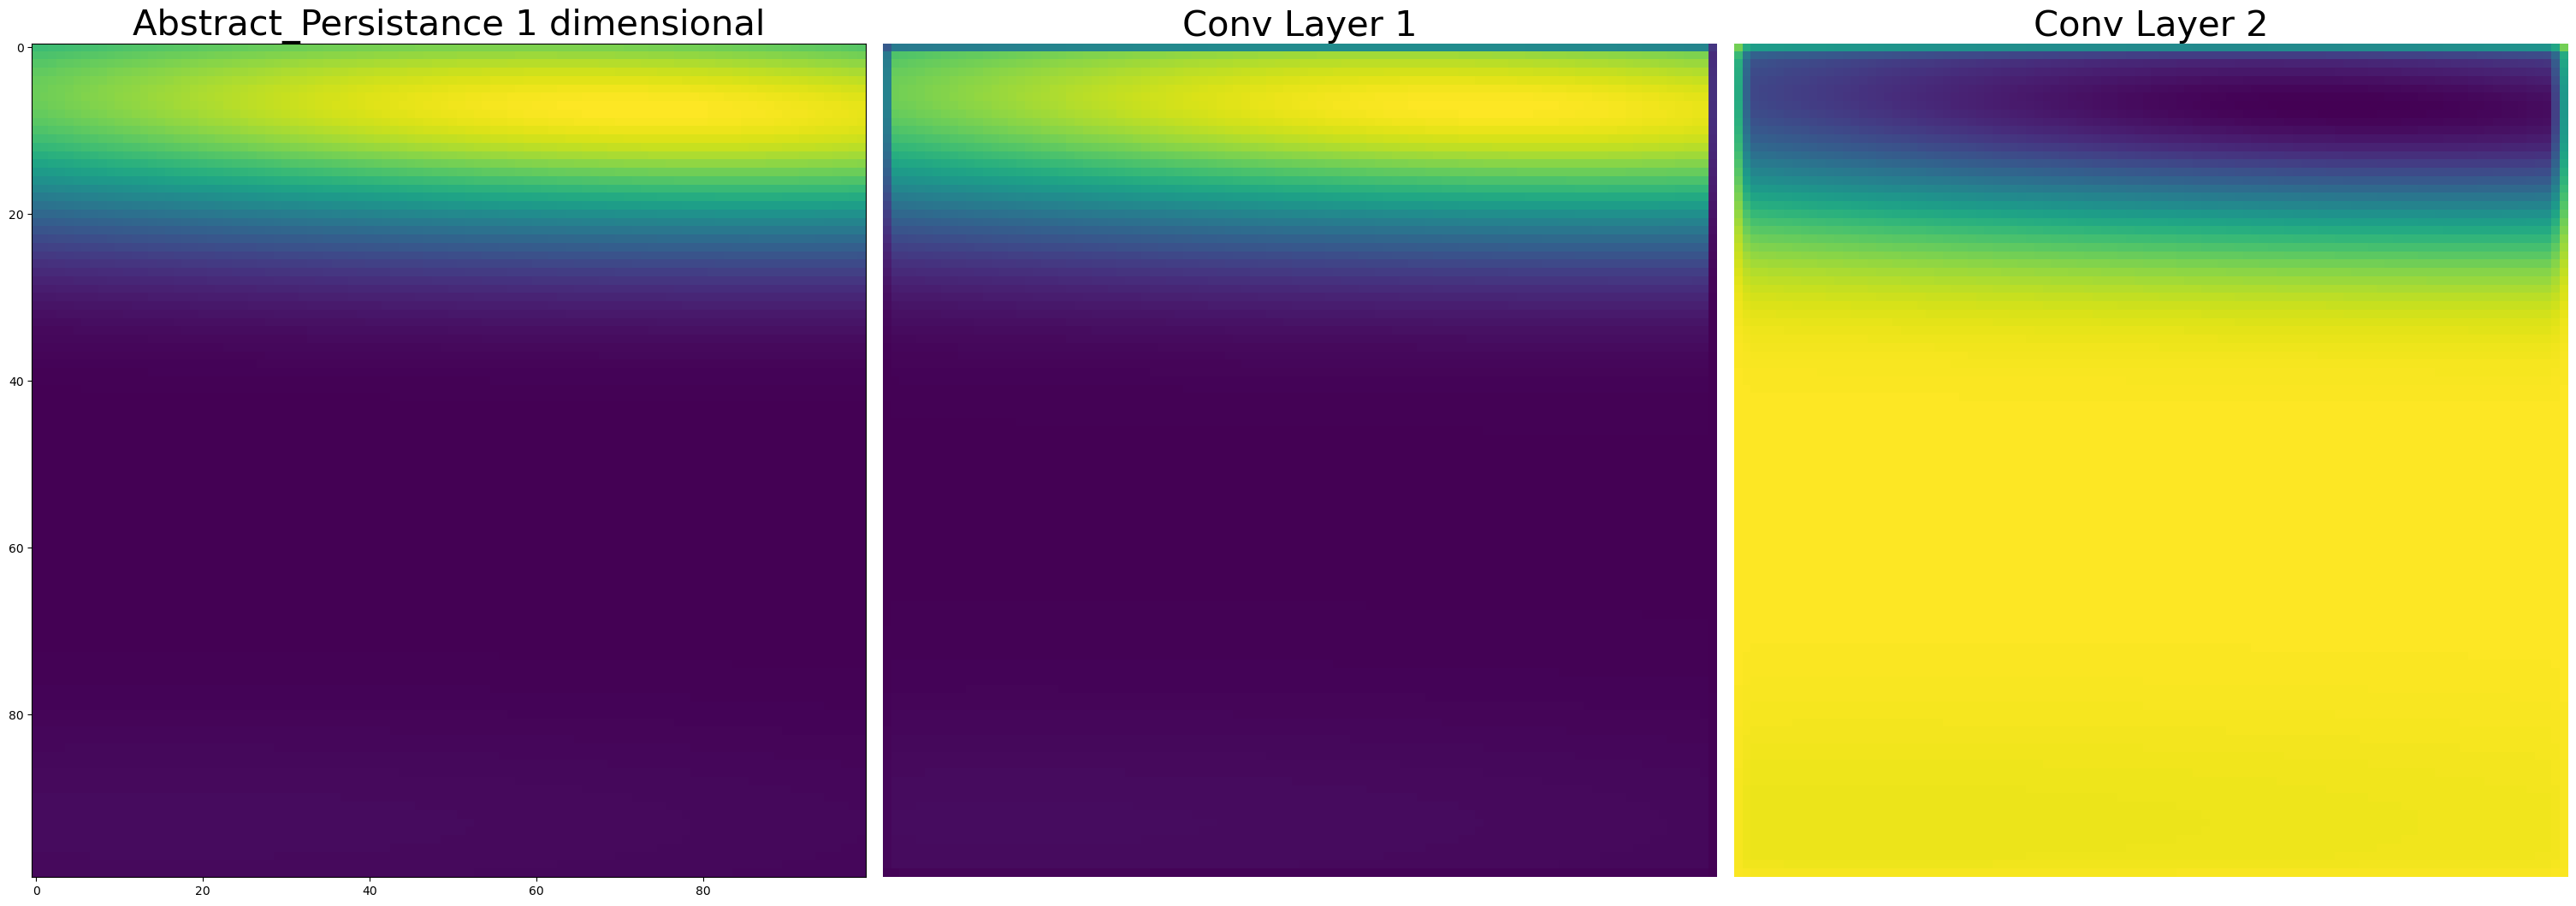

In [17]:
feature_viz_persistance(model_dual_lap_abstract, abstract_persistence_images, "Abstract_Persistance", 1)

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


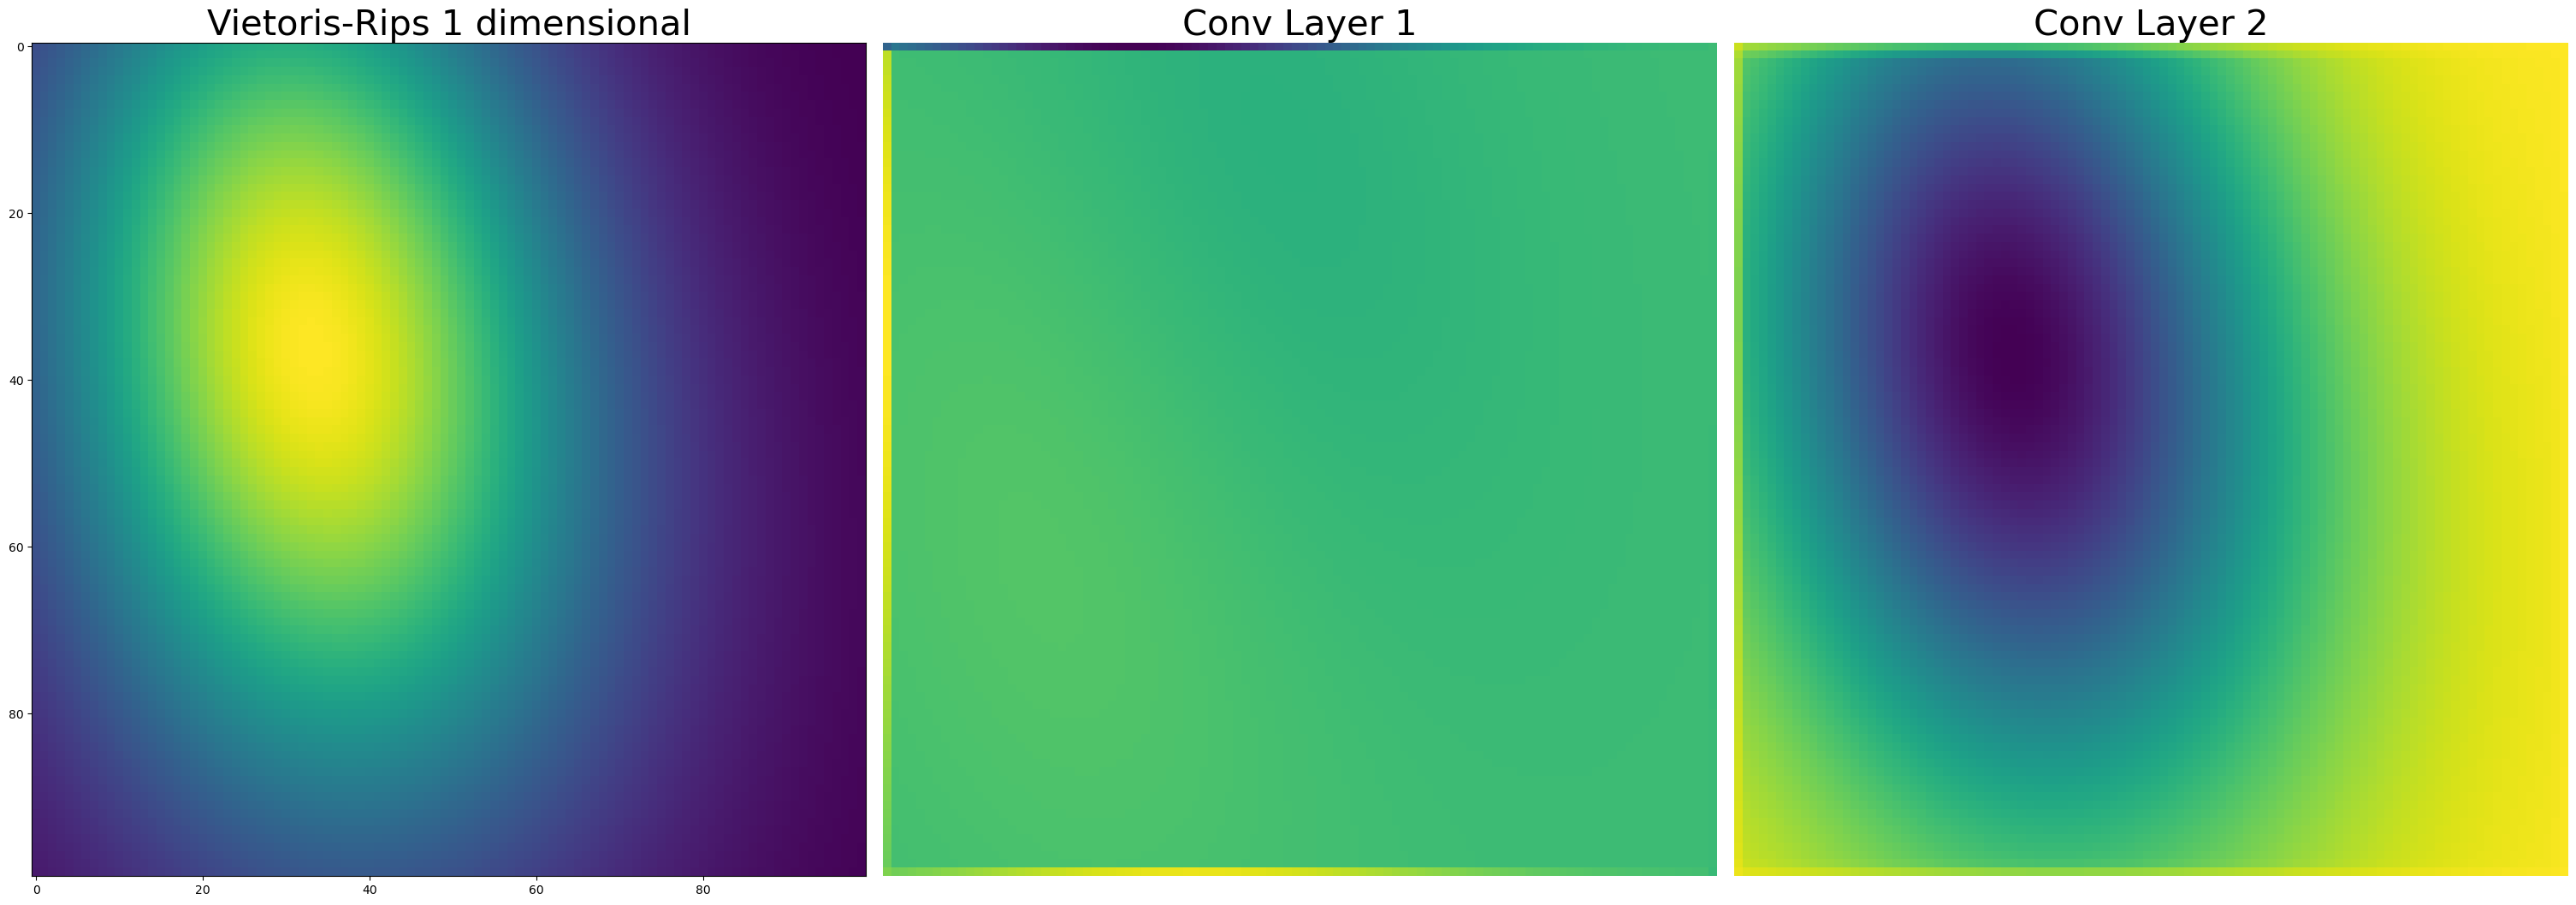

In [18]:
feature_viz_persistance(model_dual_lap_vr, vr_persistence_images, "Vietoris-Rips", 1)

2
torch.Size([16, 1000, 1000])
torch.Size([32, 1000, 1000])
(1000, 1000)
(1000, 1000)


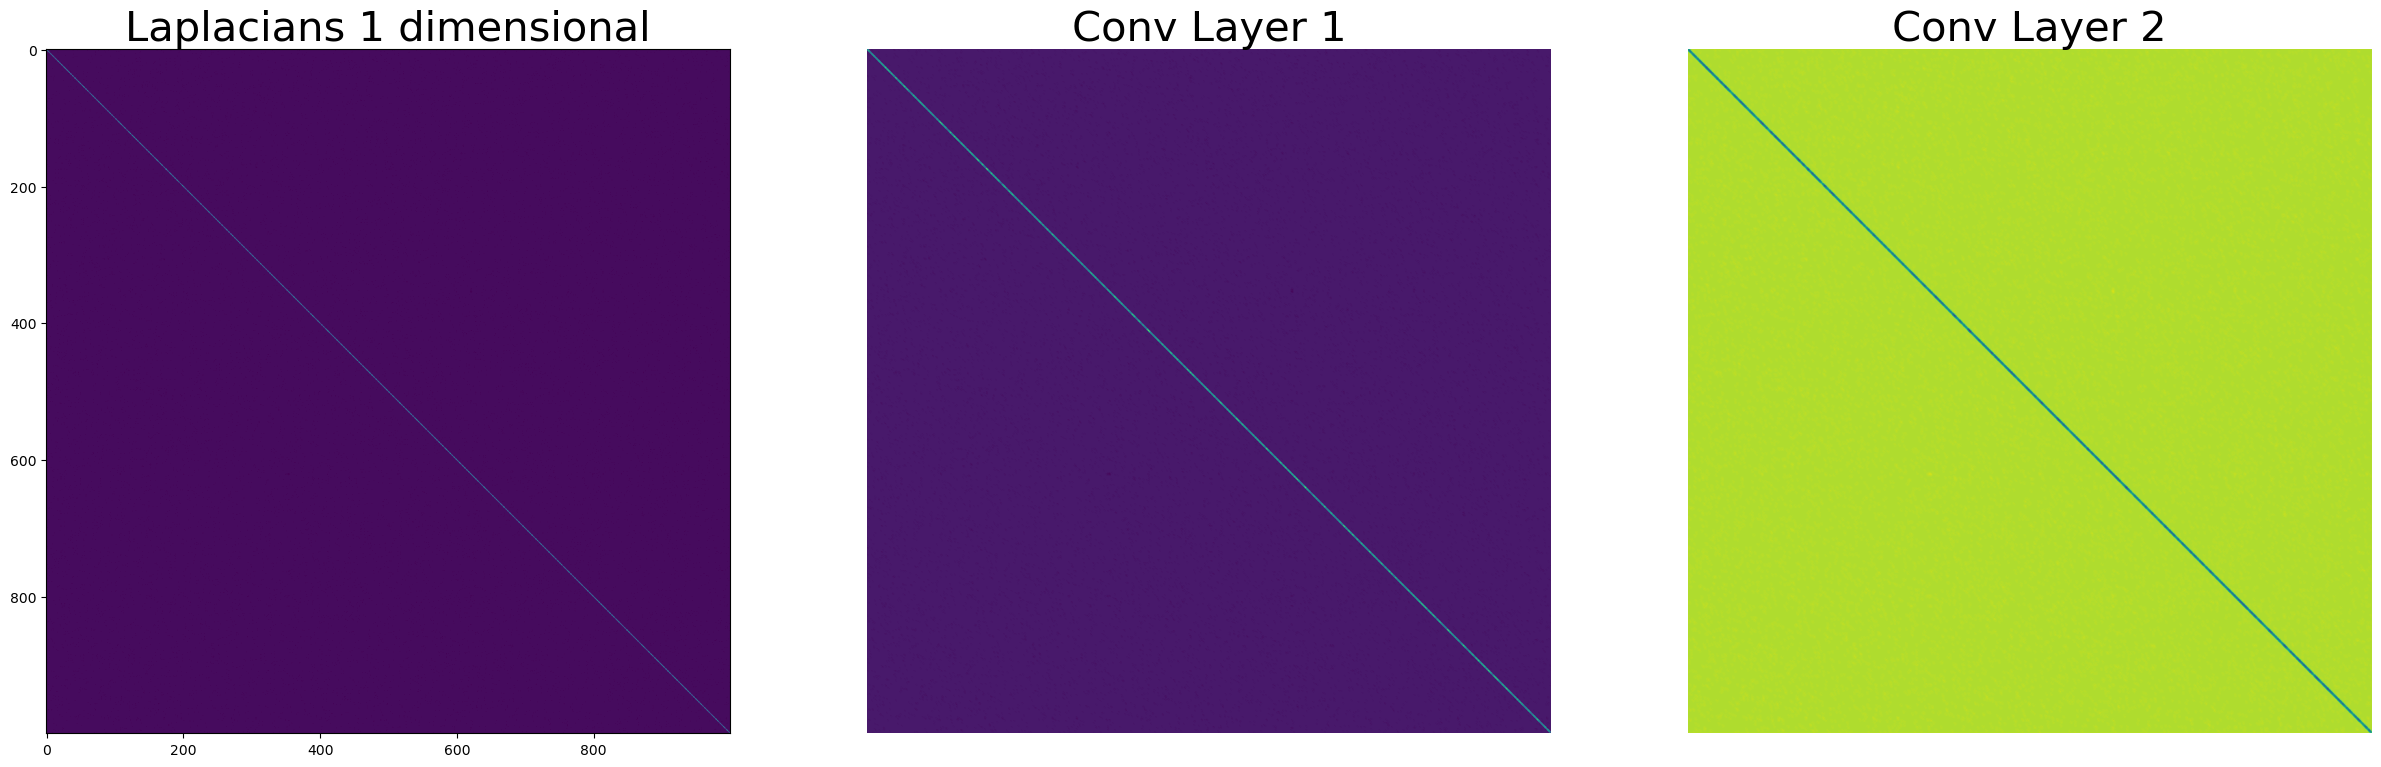

In [19]:
single_viz(lap, laplacians, "Laplacians", 1)